# <a id='top'>Formula 1 visualizations and performance metrics for the 2019 season</a>

In this notebook I use SQL to pull data from the database created in the database initialization notebook to generate visualizations and analyze driver / team performance with 3 key metrics: finishing position vs. start position, retirements, and overall consistency.

#### Table of Contents

- [1 Preparation](#1)
    - [1.1 Imports and other configurations](#1.1)
    - [1.2 Queries](#1.2)
    - [1.3 Season Info](#1.3)
- [2 Race Traces](#2)
- [3 Finishing position vs. starting position](#3)
- [4 Retirements](#4) 

- [5 lap-by-lap Consistency](#5)
    - [5.1 Filtering](#5.1)
    - [5.2 Plotting lap time distribution for 1 race](#5.2)
    - [5.3 Coefficients of variation over a season](#5.3)
- [6 Conclusion](#6)

**Associated links:**
- [Database initialization](https://nbviewer.jupyter.org/github/apalermo01/Formula-1-statistics/blob/main/Database%20initialization%20.ipynb)
- [Github repo](https://github.com/apalermo01/Formula-1-statistics)

# 1 <a id='1'>Preparation</a> 
[back to top](#top)

## 1.1 <a id='1.1'>Imports and other configurations</a>
[back to top](#top)

In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [46]:
# basics
import numpy as np
import pandas as pd
import math

# visualization libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
import seaborn as sns

# Sql
from psycopg2 import connect, extensions, sql

# other
from datetime import datetime, time, date
from collections import defaultdict

# Load login info for postgres. 
with open("postgres_login_info.txt") as f: 
    login_info = f.read()
mpl.rcParams['figure.max_open_warning'] = 50

%config InlineBackend.figure_format = 'svg'

BIG_FONT = 18
MED_FONT = 10
SMALL_FONT = 9

sns.set_style("darkgrid")

Define a function the queries the database.

In [6]:
def query(text, var):
    """Run a query on the Formula_1_statistics database using the text input
    Parameters
    ---------
    text: string
        SQL code to run
    dictionary: var
        parameters passed to query
    Returns
    ---------
    DataFrame containing the result of the submitted query
    
    """
    with connect(login_info) as conn, conn.cursor() as cur:  
        autocommit = extensions.ISOLATION_LEVEL_AUTOCOMMIT
        conn.set_isolation_level(autocommit)
        
        query = sql.SQL(text)
        cur.execute(query, var)
        return pd.DataFrame(cur.fetchall(), columns = [desc[0] for desc in cur.description])

For plotting, define a few dictionaries for team colors and abreviations ([source](https://www.reddit.com/r/formula1/comments/609hcd/f1_2017_team_color_hex_codes/))*.

\*Team color for Renault was adjusted for better visibility on a line plot

In [7]:
colors = defaultdict(lambda: '#FFFFFF', {
                     'Mercedes'      : '#00D2BE', 
                     'Ferrari'       : '#C00000', 
                     'Red Bull'      : '#0600EF', 
                     'Renault'       : '#B9B203',
                     'Haas F1 Team'  : '#787878', 
                     'Racing Point'  : '#F596C8', 
                     'Force India'   : '#F596C8', 
                     'AlphaTauri'    : '#C8C8C8',
                     'Toro Rosso'    : '#469BFF',
                     'McLaren'       : '#FF8700', 
                     'Alfa Romeo'    : '#960000',
                     'Sauber'        : '#960000',
                     'Williams'      : '#0082FA', 
                     'Lotus F1'      : '#FFB800',
                     'Manor Marussia': '#6E0000'
                    })

team_abbrev = defaultdict(lambda: 'NA', {
                     'Mercedes'      : 'Merc', 
                     'Ferrari'       : 'Fer', 
                     'Red Bull'      : 'RB', 
                     'Renault'       : 'Ren', 
                     'Haas F1 Team'  : 'Has', 
                     'Racing Point'  : 'RP', 
                     'Force India'   : 'FI', 
                     'AlphaTauri'    : 'AT', 
                     'Toro Rosso'    : 'TR', 
                     'McLaren'       : 'McL', 
                     'Alfa Romeo'    : 'AR', 
                     'Sauber'        : 'Sau', 
                     'Williams'      : 'Wil',
                     'Lotus F1'      : 'Lot', 
                     'Manor Marussia': 'MM'
                    })

## 1.2 <a id='1.2'>Queries</a>
[back to top](#top)

Define queries to do the following: 

- Get lap times for both a single race and over a whole season. 

- Get the results for a given race

In [8]:
#text = """SELECT * FROM drivers WHERE driverref = 'hamilton'"""
text = """SELECT * FROM drivers WHERE driverref ilike %(ref)s"""
query(text, var={'ref': '%ham%'})

,driverid,driverref,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44.0,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,101,brabham,NaN,None,David,Brabham,1965-09-05,Australian,http://en.wikipedia.org/wiki/David_Brabham
2,150,gary_brabham,NaN,None,Gary,Brabham,1961-03-29,Australian,http://en.wikipedia.org/wiki/Gary_Brabham
3,356,jack_brabham,NaN,None,Jack,Brabham,1926-04-02,Australian,http://en.wikipedia.org/wiki/Jack_Brabham
4,416,clapham,NaN,None,David,Clapham,1931-05-18,South African,http://en.wikipedia.org/wiki/David_Clapham
5,463,chamberlain,NaN,None,Jay,Chamberlain,1925-12-29,American,http://en.wikipedia.org/wiki/Jay_Chamberlain
6,708,duncan_hamilton,NaN,None,Duncan,Hamilton,1920-04-30,British,http://en.wikipedia.org/wiki/Duncan_Hamilton_(...
7,745,graham_whitehead,NaN,None,Graham,Whitehead,1922-04-15,British,http://en.wikipedia.org/wiki/Graham_Whitehead
8,784,hampshire,NaN,None,David,Hampshire,1917-12-29,British,http://en.wikipedia.org/wiki/David_Hampshire


In [9]:
def get_lap_distribution(firstname='', lastname='', driverref='', code='', race='', year=None):
    """Query the database to get the lap time distribution for 1 driver over the course of 1 race. 
    
    Parameters 
    ---------
    firstname: string
        driver's first name
    lastname: string
        driver's last name
    driverref: string
        driver reference- can substitute for first name and last name (e.g. pass driverref="hamilton" instead of 
        firstname="Lewis", lastname="Hamilton")
    code: string
        3 letter driver reference (e.g. "HAM")
    race: string
        race name, must uniquely match any word in the race name (e.g. name="British" for "British grand prix")
    year: int
        year in which the race occured
        
    Returns
    ---------
    DataFrame with lap times and driver information
    """
    
    
    text = """
    
    -- Get a list of lap times for the specific race
    WITH times AS (SELECT EXTRACT(MINUTES FROM lap_times.time)*60 +
                            EXTRACT(SECONDS FROM lap_times.time) AS lap_time, 
                        lap_times.lap, 
                        lap_times.position, 
                        lap_times.driverid, 
                        lap_times.raceid,
                        EXTRACT(YEAR FROM races.date) AS year
                 FROM lap_times 
                 JOIN races ON lap_times.raceid = races.raceid 
                 JOIN circuits ON races.circuitid = circuits.circuitid
                 WHERE ((races.name iLike %(race)s) AND year = %(year)s)
                 ),
   
   -- Get the pit stops. 
    pits AS (SELECT pit_stops.driverid, 
                    pit_stops.raceid, 
                    pit_stops.stop, 
                    pit_stops.lap AS pit_lap, 
                    pit_stops.time, 
                    pit_stops.duration
             FROM pit_stops
             JOIN races ON pit_stops.raceid = races.raceid
             JOIN drivers ON pit_stops.driverid = drivers.driverid
             WHERE(
                  (races.name iLike %(race)s) 
                   AND year = %(year)s
                   AND ((drivers.forename iLike %(firstname)s
                       AND drivers.surname iLike %(lastname)s) 
                        OR drivers.driverref iLike %(driverref)s
                        OR drivers.code iLike %(code)s)
                  )
    ), 
    
    average_lap AS (SELECT AVG(times.lap_time) AS time FROM times) 
              
              
    SELECT lap_times.lap,
           EXTRACT(MINUTES FROM lap_times.time)*60 + EXTRACT(SECONDS FROM lap_times.time) AS lap_time,
           CASE
               WHEN lap_times.lap IN (SELECT pits.pit_lap FROM pits) THEN TRUE
               ELSE FALSE
           END AS pit_lap, 
           lap_times.position,
           drivers.forename, 
           drivers.surname, 
           drivers.code, 
           races.name, 
           races.year, 
           status.status
           
    FROM lap_times
    
    JOIN drivers ON drivers.driverid = lap_times.driverid
    JOIN races ON races.raceid       = lap_times.raceid
    JOIN results ON results.raceid   = lap_times.raceid
    JOIN status ON results.statusid  = status.statusid
    
    WHERE(
        
        -- filter drivers table to specified driver
        ((drivers.forename iLike %(firstname)s
        AND drivers.surname iLike %(lastname)s)
        OR drivers.driverref iLike %(driverref)s
        OR drivers.code iLike %(code)s)
        
        -- filter results to specified driver
        AND results.driverid = (
                SELECT driverid
                FROM drivers
                WHERE ((drivers.forename iLike %(firstname)s
                        AND drivers.surname iLike %(lastname)s)
                        OR drivers.driverref iLike %(driverref)s
                        OR drivers.code iLike %(code)s)
                LIMIT 1
                )

        -- filter races
        AND races.name iLike %(race)s AND races.year = %(year)s
    ) 
    """
    
    return query(text, {'firstname': '%' + firstname + '%', 
                        'lastname': '%' + lastname + '%', 
                        'driverref': '%' + driverref + '%', 
                        'code': '%' + code + '%', 
                        'race': '%' + race + '%', 
                        'year': year})

In [10]:
get_lap_distribution(code="HAM", race="British", year=2019).head()

,lap,lap_time,pit_lap,position,forename,surname,code,name,year,status
0,1,94.461,True,1,Valtteri,Bottas,BOT,British Grand Prix,2019,Finished
1,44,89.016,False,2,Valtteri,Bottas,BOT,British Grand Prix,2019,Finished
2,24,94.143,True,5,Max,Verstappen,VER,British Grand Prix,2019,Finished
3,2,91.644,False,1,Valtteri,Bottas,BOT,British Grand Prix,2019,Finished
4,25,90.740,False,5,Max,Verstappen,VER,British Grand Prix,2019,Finished


In [11]:
def get_race_distribution(race, year):
    """Query the database to get the lap times of every driver for a specified race. 
    Parameters 
    ---------
    race: string
        race name, must uniquely match any word in the race name (e.g. name="British" for "British grand prix")
    year: int
        year in which the race occured
        
    Returns
    ---------
    DataFrame with lap times and information for every driver during a race
    
    """
    
    text = f"""

    SELECT drivers.forename AS firstname,
           drivers.surname AS lastname,
           drivers.code, 
           drivers.driverid, 
           drivers.driverref,
           results.positionorder,
           races.name AS race_name, 
           constructors.name AS team
           
    FROM drivers
    
    JOIN results ON results.driverid = drivers.driverid
    JOIN races ON races.raceid = results.raceid
    JOIN constructors ON constructors.constructorid = results.constructorid
    
    WHERE races.year = %(year)s AND races.name iLike %(race)s
    """
    
    drivers_df =  query(text, {'year': year, 'race': '%' + race + '%'});

    frames = [get_lap_distribution(driverref=ref, race=race, year=year) 
              for ref in drivers_df['driverref']];
    
    # replace None with np.nan- this was found with Sainz in the 2019 Belgian grand prix. 
    df = pd.concat(frames, ignore_index=True).sort_values(by="lap_time")
    df['team'] = [drivers_df[drivers_df['code'] == i]['team'].values[0] for i in df['code']]
    df.fillna(value=np.nan, inplace=True)
    
    return df

In [12]:
def get_race_results(race=None, year=None): 
    """Get the results from one race. 
    
    Parameters 
    ---------
    race: string
        race name, must uniquely match any word in the race name (e.g. name="British" for "British grand prix")
    year: integer
        year in which the race occured
        
    Returns
    ---------
    DataFrame 
        The associated result data
    """
        
    text = f"""
    SELECT drivers.forename, 
           drivers.surname,
           drivers.code, 
           constructors.name AS team, 
           races.name,
           results.grid, 
           results.position, 
           results.positiontext, 
           results.points, 
           results.laps, 
           results.fastestlap, 
           results.fastestlaptime, 
           status.status
            
    FROM RESULTS
    
    JOIN drivers ON results.driverid = drivers.driverid
    JOIN races ON results.raceid = races.raceid
    JOIN status ON results.statusid = status.statusid
    JOIN constructors ON constructors.constructorid = results.constructorid
    
    WHERE races.year = %(year)s AND races.name iLike %(race)s
    """
    return query(text, {'year': year, 'race': '%' + race + '%'})

## <a id='1.3'>1.3 Season info</a>
[back to top](#top)

Test the get_race_results function. In the project, I will frequently refer to drivers by their last name instead of the 3-letter code shown on the plots. This table can be used to look up which drivers I’m referring to if there is any confusion. 

In [13]:
get_race_results(race="British", year=2019).head(20)

,forename,surname,code,team,name,grid,position,positiontext,points,laps,fastestlap,fastestlaptime,status
0,Lewis,Hamilton,HAM,Mercedes,British Grand Prix,2,1.0,1,26,52,52,00:01:27.369000,Finished
1,Valtteri,Bottas,BOT,Mercedes,British Grand Prix,1,2.0,2,18,52,47,00:01:27.406000,Finished
2,Charles,Leclerc,LEC,Ferrari,British Grand Prix,3,3.0,3,15,52,47,00:01:29.313000,Finished
3,Pierre,Gasly,GAS,Red Bull,British Grand Prix,5,4.0,4,12,52,48,00:01:29.544000,Finished
4,Max,Verstappen,VER,Red Bull,British Grand Prix,4,5.0,5,10,52,45,00:01:29.272000,Finished
5,Carlos,Sainz,SAI,McLaren,British Grand Prix,13,6.0,6,8,52,50,00:01:29.757000,Finished
6,Daniel,Ricciardo,RIC,Renault,British Grand Prix,7,7.0,7,6,52,50,00:01:29.624000,Finished
7,Kimi,Räikkönen,RAI,Alfa Romeo,British Grand Prix,12,8.0,8,4,52,51,00:01:30.034000,Finished
8,Daniil,Kvyat,KVY,Toro Rosso,British Grand Prix,17,9.0,9,2,52,51,00:01:29.910000,Finished
9,Nico,Hülkenberg,HUL,Renault,British Grand Prix,10,10.0,10,1,52,51,00:01:29.949000,Finished


Get the final season results. 

In [14]:
def get_final_season_results(year=2019, res="driver"): 
    """Get the final season results for the drivers or team championship"""
    
    if res == "driver": 
        text = f"""
        SELECT drivers.forename, 
               drivers.surname, 
               drivers.code,  
               driver_standings.points,
               driver_standings.wins
        FROM driver_standings
        JOIN races ON driver_standings.raceid = races.raceid
        JOIN drivers ON driver_standings.driverid = drivers.driverid
        WHERE races.year = %(year)s
        AND races.round = (SELECT MAX(round) FROM races WHERE races.year=%(year)s)
        ORDER BY driver_standings.points DESC
        """
    elif res == "constructor": 
                text = f"""
        SELECT constructors.name,  
               constructor_standings.points,
               constructor_standings.wins
        FROM constructor_standings
        JOIN races ON constructor_standings.raceid = races.raceid
        JOIN constructors ON constructor_standings.constructorid = constructors.constructorid
        WHERE races.year = %(year)s
        AND races.round = (SELECT MAX(round) FROM races WHERE races.year=%(year)s)
        """
            
    return query(text, {'year': year})

In [15]:
get_final_season_results(year=2019)

,forename,surname,code,points,wins
0,Lewis,Hamilton,HAM,413,11
1,Valtteri,Bottas,BOT,326,4
2,Max,Verstappen,VER,278,3
3,Charles,Leclerc,LEC,264,2
4,Sebastian,Vettel,VET,240,1
5,Carlos,Sainz,SAI,96,0
6,Pierre,Gasly,GAS,95,0
7,Alexander,Albon,ALB,92,0
8,Daniel,Ricciardo,RIC,54,0
9,Sergio,Pérez,PER,52,0


# 2 <a id='2'>Race traces</a>
[back to top](#top)

Plot the difference between a driver’s cumulative lap time and the overall average cumulative lap time for the British Grand Prix. (inspired by [jtrotman's](https://www.kaggle.com/jtrotman/f1-race-traces-2019) notebook. This includes a breakdown of race traces by team to look at teammate head-to-head performance. 

For every driver, plot the difference in the driver's cumulative lap time with the average cumulative lap time. 

In [59]:
def get_race_trace(race=None, 
                   year=None, 
                   make_plot=True, 
                   save_fig=False, 
                   filename="Race trace.png"):
    
    """Get race trace data and plot (optional).  
    
    Calculate the average cumulative lap time for each lap. For example, if the average lap times for the first 3 laps 
    of a hypothetical race were 95, 85, and 86 seconds, then the average cumulative lap times would be 95, 180, and 266
    seconds. Then, for each driver, calculate the difference between the driver's cumulative lap time and the average 
    (called the delta). A negative delta indicates that the driver has a faster pace than the average lap. 
    
    
    Parameters 
    ---------
    race: string
        race name, must uniquely match any word in the race name (e.g. name="British" for "British grand prix")
    year: int
        year in which the race occured
    make_plot: 
        If true, will generate a plot of the race traces for a given race and return the axis handles.
        
    Returns
    ---------
    DataFrame 
        The associated race distribution
    Series
        the average cumulative lap time of each lap
    axis (optional)
        axis handles of the plot, if make_plot is True
    """
    
    # Get the race data. 
    df = get_race_distribution(race=race, year=year).sort_values(by=['code', 'lap'])
    
    # Declare a new column with the differences from the average.
    df['delta'] = np.nan
    
    laps = df['lap'].sort_values().unique()
    
    # Calculate the average cumulative lap time. 
    time = pd.Series([np.nanmean(df['lap_time'][df['lap'] == lap]) for lap in laps]).cumsum(skipna=True)
        
    # Set up plot parameters. 
    if make_plot == True: 
        linetypes = ["-", "--"]
        sns.set_style("darkgrid")
        fig, ax = plt.subplots(figsize=[12, 5])
    
    for team in df['team'].unique(): 
        drivers = df['code'][df['team'] == team].unique()
        
        for i in range(len(drivers)):  
            
            # Calculate the difference between the driver's cumulative time and average cumulative time. 
            delta = pd.Series([df['lap_time'][(df['code'] == drivers[i]) & (df['lap'] == lap)].values[0]
                               for lap in laps if
                               len(df['lap_time'][(df['code'] == drivers[i]) & (df['lap'] == lap)]) > 0]
                              ).cumsum(skipna=True) - time
            
            # Update the DataFrame with the calculated deltas. 
            for lap in laps:
                df.loc[(df['code'] == drivers[i]) & (df['lap'] == lap), 'delta'] = delta[lap-1]
            
            # Skip the rest if no plotting.
            if make_plot == False: 
                continue
            
            # Use the legend to indicate drivers that retired or finished a lap down.
            if df['status'][(df['code'] == drivers[i])].values[0] != "Finished": 
                label = drivers[i] + " (" + df['status'][df['code'] == drivers[i]].values[0] + ")"
            else: 
                label = df['code'][df['code'] == drivers[i]].values[0]
                
            # Draw the plot.     
            plt.plot(delta, 
                     color=colors[df['team'][df['code'] == drivers[i]].values[0]], 
                     label=label, 
                     linestyle=linetypes[i],
                     linewidth=1)
    
    # Format figure. 
    if make_plot == True:
        ax.set_title(f"race traces for the {year} {df['name'].values[0]}", fontsize=BIG_FONT)
        ax.set_xlabel("lap", fontsize=MED_FONT)
        ax.set_ylabel("delta (seconds)", fontsize=MED_FONT)
        ax.legend(bbox_to_anchor=(0.5, -0.2), loc='center', ncol=10, fontsize=MED_FONT)    
        if save_fig: 
            plt.savefig(filename, bbox_inches='tight')
        return df, time, ax
    else: 
        return df, time

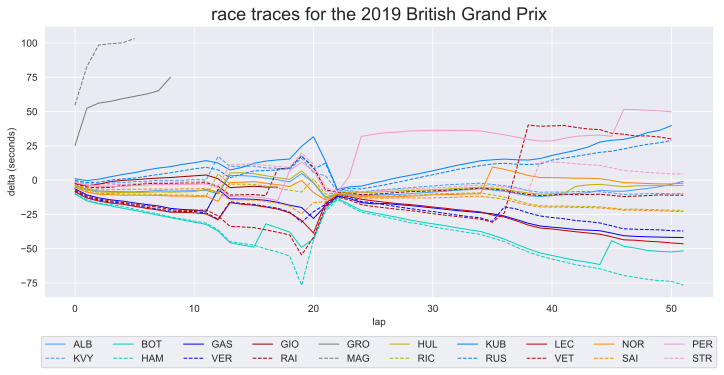

In [60]:
get_race_trace(race="British", year=2019, make_plot=True, 
               save_fig=True, filename="2019 British Grand Prix race trace.png");

**Observations** 
- In this figure, a **negative** delta indicates the driver's cumulative lap time is **below** the average cumulative lap time- so the driver on the bottom is in the lead (this was BOT until lap 15 when HAM took the lead and retained it for the rest of the race). 

- Jumps in the deltas (BOT on lap 45, NOR on lap 35) indicate pit stops. 

- The shorter lines are either due to retirements (e.g. GRO and MAG) or finishing a lap down (e.g. KUB, RUS, VET, and PER).  
- This race had a safety car from lap 20-23, which is evident from the bunching up on lap 23. 


Split this plot by team to compare teammates

In [18]:
def plot_team_trace(race=None, year=None):     
    """Function to plot the race traces split by team. 
    
    Use get_race_trace() to calculate the deltas, the make the plot with one team for each subplot. 
    
    Parameters 
    ---------
    race: string
        race name, must uniquely match any word in the race name (e.g. name="British" for "British grand prix")
    year: int
        year in which the race occured
        
    Returns
    ---------
    DataFrame 
        The associated race distribution
    Series
        the average cumulative lap time of each lap
    axis
        axis handles of the plot
    """
    
    # Get race data. 
    df, time = get_race_trace(race=race, year=year, make_plot=False)
    
    # Format plot. 
    sns.set_style("darkgrid")
    fig, ax = plt.subplots(nrows=len(df['team'].unique()), figsize=[8, 24], sharex=True)
    plt.subplots_adjust(hspace=0.5)
    laps = df['lap'].sort_values().unique()
    linetypes = ["-", "--"]
    
    # Loop through each team. 
    for index, team in pd.Series(df['team'].unique()).items(): 
        drivers = df['code'][df['team'] == team].unique()
        
        # Loop through each driver in the team. 
        for i in range(len(drivers)): 
            
            # Configure labels. 
            if df['status'][(df['code'] == drivers[i])].values[0] != "Finished": 
                label = drivers[i] + " (" + df['status'][df['code'] == drivers[i]].values[0] + ")"
            else: 
                label = df['code'][df['code'] == drivers[i]].values[0]
            
            # Draw plot. 
            sns.lineplot(x=df['lap'][df['code'] == drivers[i]].values, 
                         y=df['delta'][df['code'] == drivers[i]].values,
                         ax=ax[index], 
                         label=label, 
                         color=colors[df['team'][df['code'] == drivers[i]].values[0]], 
                         linestyle=linetypes[i], 
                         linewidth=1)
            # This one is producing unusual results for some unkonwn reason
#             ax[index].plot(df['delta'][df['code'] == drivers[i]].values, 
#                            color=colors[df['team'][df['code'] == drivers[i]].values[0]], 
#                            linestyle=linetypes[i], 
#                            label=label, 
#                            linewidth=1)
            
            # Format axes. 
            ax[index].set_title(f"{team}", fontsize=MED_FONT)
            ax[index].set_ylabel("delta (seconds)", fontsize=MED_FONT)
            ax[index].legend(bbox_to_anchor=(1,1), loc='upper left', fontsize=SMALL_FONT)
            ax[index].xaxis.set_major_locator(ticker.MultipleLocator(5))
    
    # Format figure. 
    ax[-1].set_xlabel("lap")
    fig.suptitle(f"Race traces subdivided by team for the {year} {df['name'].values[0]}", fontsize=BIG_FONT)
    fig.tight_layout()
    fig.subplots_adjust(top=0.955)
    
    return df, time, ax

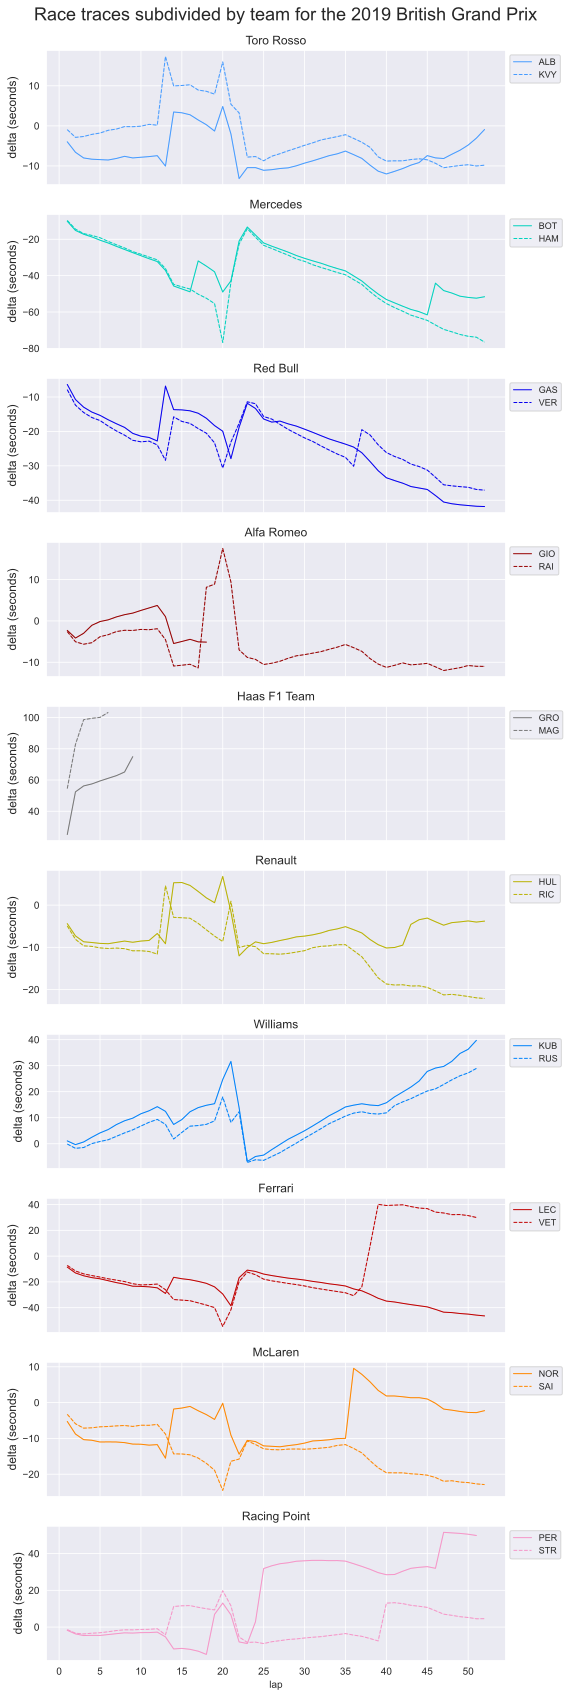

In [19]:
plot_team_trace(race="British", year=2019);

**Observations** 
- On lap 37, VET and VER [collided](https://youtu.be/TjiCXhGuLgw?t=343), which explains why VET lost so much time. 

- PER had a terrible pace after the safety car ended on lap 23.

- The Mercedes were incredibly close through almost the entire race. 

- ALB had significantly better pace than KYV until the closing laps. This might be due to old tires "falling off the cliff" and loosing grip. 

# 3 <a id='3'>Finishing position vs. grid position</a>
[back to top](#top)

For each driver, find the distribution in their qualifying position, finishing position, and difference (i.e. positions gained / lost during a race).

During some seasons, there were driver swaps (e.g. the [team switch](https://www.formula1.com/en/latest/article.analysis-why-red-bull-made-their-latest-blockbuster-driver-swap.5OSpVBQ1sdbxO5VEj80ykZ.html) between Pierre Gasly and Alex Albon in 2019). Write a function to take a DataFrame with all the race results for the season and append a team abbreviation to 'code' if a given driver switched teams mid-season.

In [20]:
def team_switches(df): 
    """Append team abbreviation to 'code' if any driver has driven for more than 1 team during a season."""
    
    for driver in df['code']: 
        if len(df['team'][df['code'] == driver].unique())>1: 
            for team in df['team'][df['code'] == driver].unique(): 
                df.loc[(df['code'] == driver) & (df['team'] == team), 'code'] = f"{driver}\n({team_abbrev[team]})"
    return df

Call get_race_results() for every race in the season to aggregate start and finish positions to the full season. 

In [21]:
def get_season_results(year=None, min_races=3, team_change=True): 
    """Get the results from one race. 
    
    Parameters 
    ---------
    year: integer
        Season of interest
    min_races: integer
        In some seasons, a reserve driver had to stand in in-place of a full-time driver due to injury or illness. 
        Filter these out if they've only driven in a few races (3 by default) since there won't be enough data
    
    Returns
    ---------
    DataFrame 
        the associated season data
    """
    
    # Get a list of races. 
    text = f"""
    SELECT races.name
    FROM races
    WHERE races.year = %(year)s
    """
    races = query(text, var={'year': year}).to_numpy()
    df = pd.DataFrame()
    
    # Loop through races and append results. 
    for race in races: 
        df = df.append(get_race_results(race=race[0], year=year), ignore_index=True)
        
    # If a driver only drove for a team in a limited number of races, drop those results.
    for team in df['team'].unique(): 
        for code in df['code'][df['team'] == team].unique(): 
            if len(df['name'][(df['code'] == code) & (df['team'] == team)]) < min_races: 
                df = df.drop(df[(df['team'] == team) & (df['code'] == code)].index)
    
    # if 0 is in 'grid', set it to 20 (likely no time set- found with RAI in Italian GP 2019)
    df.loc[df['grid'] == 0, 'grid'] = 20
    
    # Account for team changes. 
    if team_change: 
        df = team_switches(df)
    return df

In [22]:
get_season_results(year=2019)

,forename,surname,code,team,name,grid,position,positiontext,points,laps,fastestlap,fastestlaptime,status
0,Valtteri,Bottas,BOT,Mercedes,Australian Grand Prix,2,1.0,1,26,58,57.0,00:01:25.580000,Finished
1,Lewis,Hamilton,HAM,Mercedes,Australian Grand Prix,1,2.0,2,18,58,57.0,00:01:26.057000,Finished
2,Max,Verstappen,VER,Red Bull,Australian Grand Prix,4,3.0,3,15,58,57.0,00:01:26.256000,Finished
3,Sebastian,Vettel,VET,Ferrari,Australian Grand Prix,3,4.0,4,12,58,16.0,00:01:27.954000,Finished
4,Charles,Leclerc,LEC,Ferrari,Australian Grand Prix,5,5.0,5,10,58,58.0,00:01:26.926000,Finished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,Antonio,Giovinazzi,GIO,Alfa Romeo,Abu Dhabi Grand Prix,16,16.0,16,0,54,28.0,00:01:43.256000,+1 Lap
416,George,Russell,RUS,Williams,Abu Dhabi Grand Prix,18,17.0,17,0,54,50.0,00:01:43.074000,+1 Lap
417,Pierre,Gasly,GAS\n(TR),Toro Rosso,Abu Dhabi Grand Prix,11,18.0,18,0,53,53.0,00:01:42.414000,+2 Laps
418,Robert,Kubica,KUB,Williams,Abu Dhabi Grand Prix,19,19.0,19,0,53,51.0,00:01:44.500000,+2 Laps


Now make the plots. 

In [23]:
def plot_start_finish_data(year=None, min_races=3, df=None, remove_extremes=False, toss_upper=3, toss_lower=3, **kwargs):
    """Plot starting grid position, finishing position, and positions gained / lost during a race.  
    
    Parameters 
    ---------
    year: integer
        Season of interest
    min_races: integer 
        In some season, a reserve driver had to stand in in-place of a full-time driver due to injury or illness. Filter
        these out if they've only driven in a few races (3 by default) since there won't be enough data
    df: DataFrame
        If get_season_results was previously called, the results from the previous call can be passed to avoid duplicate
        function calls. 
    **kwargs: extra arguments for sns.violinplot()
    Returns
    ---------
    DataFrame: 
        The associated season data
    axes: 
        axis handles
    """
    
    # Calculate season results if the results have not already been passed. 
    if df is None: 
        df = get_season_results(year=year, min_races=min_races).sort_values(by="team")
    
    # Toss out the top and bottom performers to examine midfield only. 
    if remove_extremes:
        results = get_final_season_results(year=year, res="driver").sort_values(by="points", ascending=False)
        top = results['code'].values[:toss_upper]
        bottom = results['code'].values[-1*(toss_lower):]
        df = df.drop(df[df['code'].isin(top) | df['code'].isin(bottom)].index)

    # Set up figure. 
    fig, ax = plt.subplots(nrows=3, figsize=[10, 12])
    plt.subplots_adjust(hspace=0.5)
    titles = [f"starting positions during the {year} season", 
              f"finishing positions during the {year} season", 
              f"number of positions gained / lost during the {year} season"]
    
    # Construct array of data to plot. 
    data = [df['grid'], df['position'], df['position']-df['grid']]
    
    # Make the plots. 
    for i in range(3):
        sns.violinplot(x=df['code'], 
                       y=data[i], 
                       ax=ax[i],
                       dodge=False, 
                       hue=df['team'], 
                       palette=colors,
                       **kwargs
                      )
        ax[i].legend(bbox_to_anchor=(1,1), loc = 'upper left', ncol=1, fontsize=MED_FONT)
        ax[i].set_title(titles[i], fontsize=BIG_FONT)
    ax[2].set_ylabel("positions gained / lost", fontsize=MED_FONT)
    return df, ax

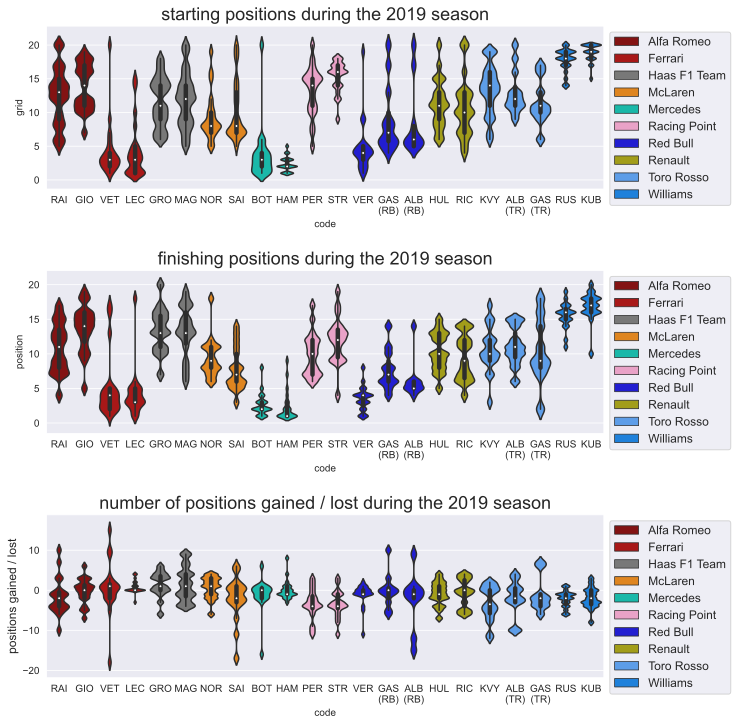

In [24]:
df, _ = plot_start_finish_data(2019, bw=0.15);

A smaller spread generally means that the driver is more consistent, although it's expected that each driver might have one or two starts from the back of the grid due to penalties for mechanical issues (e.g. engine changes). 

**Observations**

One significant observation is that both drivers for Mercedes and Ferrari consistently started and finished at the front of the grid. Similarly, both drivers for Williams started at the back of the grid. This is indicative of the imbalance in car performance. In this plot, the only reasonable comparison is between teammates (plots with the same color).

Qualifying / starting positions
- Hamilton has been remarkably consistent in qualifying
- Albon beat Gasly in the Red Bull in qualifying performance, but Gasly beat Albon in the Torro Rosso. 
- Verstappen beat both of his teammates during 2019
- Haas, Alfa Romeo, and Renault are very inconsistent in qualifying

Finishing positions
- Things appear equal between teammates, except for Red Bull
- Albon was remarkably more consistent with finishing position in the RB than Gasly
- Neither Gasly nor Albon managed to match Verstappen in finishing position. 
- Hamilton, Bottas, and Verstappen are the most consistent
- Alfa Romeo, Renault, and Haas have a large spread in both starting and finishing positions. 


There is a problem with this analysis- it favors the back of the grid (since they can only go forward) and punishes the front of the grid (since they can only go backward). To gain more objective insights in analyzing the number of positions gained / lost, we should throw out the top and bottom 3 drivers according to the driver standings.


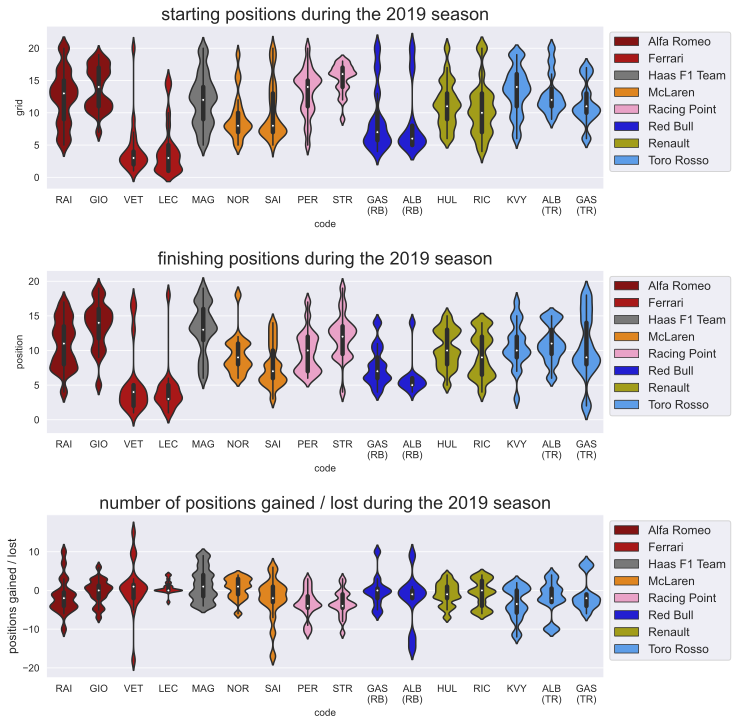

In [25]:
plot_start_finish_data(year=2019, df=df, remove_extremes=True, bw=0.2, scale="area");

**Observations**
- negative values on the 3rd plot indicate positions gained (e.g. Vettel (VET) at some point in the 2019 season gained 19 positions in a race
- Gasley seems much more suited for the Torro Rosso
- Norris had a definitive net loss of position, everyone else seemed to have gains (based on median- white dot)

# 4 <a id='4'>Retirements</a>
[back to top](#top)

A significant impact of a driver's performance over the course of a season is influenced by the car's reliability. For example, Daniel Riccardo in 2018 took a significant hit due to consecutive retirements during the summer leg of the season.

We can sort retirements into 3 broad categories: mechanical, non-mechanical, and other. In general, we can assume that non-mechanical retirements are due to driver error (i.e. crashes) while mechanical retirements are due to poor car construction. 'Other' can't be attributed to either driver or team error. In this analysis, we'll look at which drivers had the most non-mechanical retirements and which teams had the most mechanical retirements. 

First, look at 'status' and sort things into mechanical, non-mechanical, and other retirements. 

In [26]:
status = query("SELECT status FROM status", var={}).values.flatten()
status.sort()
status

array(['+1 Lap', '+10 Laps', '+11 Laps', '+12 Laps', '+13 Laps',
       '+14 Laps', '+15 Laps', '+16 Laps', '+17 Laps', '+18 Laps',
       '+19 Laps', '+2 Laps', '+20 Laps', '+21 Laps', '+22 Laps',
       '+23 Laps', '+24 Laps', '+25 Laps', '+26 Laps', '+29 Laps',
       '+3 Laps', '+30 Laps', '+38 Laps', '+4 Laps', '+42 Laps',
       '+44 Laps', '+46 Laps', '+49 Laps', '+5 Laps', '+6 Laps',
       '+7 Laps', '+8 Laps', '+9 Laps', '107% Rule', 'Accident',
       'Alternator', 'Axle', 'Battery', 'Brake duct', 'Brakes',
       'Broken wing', 'CV joint', 'Chassis', 'Clutch', 'Collision',
       'Collision damage', 'Crankshaft', 'Damage', 'Debris',
       'Did not prequalify', 'Did not qualify', 'Differential',
       'Disqualified', 'Distributor', 'Driver Seat', 'Driver unwell',
       'Driveshaft', 'Drivetrain', 'ERS', 'Electrical', 'Electronics',
       'Engine', 'Engine fire', 'Engine misfire', 'Excluded', 'Exhaust',
       'Eye injury', 'Fatal accident', 'Finished', 'Fire', 'Front win

In [27]:
non_mechanical_dnf = ['Accident', 'Broken wing', 'Collision', 'Collision damage', 'Damage', 'Disqualified',
                      'Eye injury', 'Fatal accident', 'Front wing', 'Injured', 'Injury', 'Launch control', 'Magneto', 
                      'Puncture', 'Radiator', 'Rear wing', 'Spun off', 'Stalled', 'Tyre', 'Tyre puncture']
                      
                      
mechanical_dnf = ['Alternator', 'Axle', 'Battery', 'Brake duct', 'Brakes', 'CV joint', 'Chassis', 'Clutch', 
                  'Crankshaft', 'Differential',  'Distributor', 'Driver Seat', 'Driveshaft', 'Drivetrain', 'ERS', 
                  'Electrical', 'Electronics', 'Engine', 'Engine fire', 'Engine misfire', 'Exhaust', 'Fuel', 
                  'Fuel leak', 'Fuel pipe', 'Fuel pressure', 'Fuel pump', 'Fuel rig', 'Fuel system', 'Gearbox',
                  'Halfshaft', 'Handling', 'Heat shield fire', 'Hydraulics', 'Ignition', 'Injection', 'Mechanical', 
                  'Not restarted', 'Oil leak', 'Oil line', 'Oil pipe', 'Oil pressure', 'Oil pump', 'Out of fuel',
                  'Overheating', 'Pneumatics', 'Power Unit', 'Power loss', 'Refuelling', 'Safety belt', 
                  'Safety concerns', 'Seat', 'Spark plugs', 'Steering', 'Supercharger', 'Suspension', 'Technical', 
                  'Throttle', 'Track rod', 'Transmission', 'Turbo', 'Underweight', 'Vibrations', 'Water leak', 
                  'Water pipe', 'Water pressure', 'Water pump', 'Wheel', 'Wheel bearing', 'Wheel nut', 'Wheel rim']

In [28]:
def plot_retirements(year=2019, min_races=3, df=None):
    if df is None: 
        df = get_season_results(year=year, min_races=min_races, team_change=False)


    finish_status = ["Finished", "+1 Lap", "+2 Laps", "+3 Laps"]
    
    driver_standings = get_final_season_results(year=year, res="driver")
    constructor_standings = get_final_season_results(year=year, res="constructor")
    
    # make one plot for driver retirements for things related to crashes
    df_driver = pd.DataFrame({'code': [driver for driver in df['code'].unique()], 
                              'dnfs': [len(df[(df['code']==driver) & (df['status'].isin(non_mechanical_dnf))]) 
                                       for driver in df['code'].unique()], 
                              'team': [df['team'][df['code']==driver].values[0] 
                                       for driver in df['code'].unique()], 
                              'points': [driver_standings['points'][driver_standings['code']==driver].values[0] 
                                        for driver in df['code'].unique()]
             }).sort_values(by='points', ascending=False)
    
    # make another plot for retirements related to mechanical issues, but order by team 
    df_team = pd.DataFrame({'team': [team for team in df['team'].unique()], 
                            'dnfs': [len(df[(df['team']==team) & (df['status'].isin(mechanical_dnf))]) 
                                     for team in df['team'].unique()], 
                            'points': [constructor_standings['points'][constructor_standings['name']==team].values[0]
                                       for team in df['team'].unique()]
             }).sort_values(by='points', ascending=False)

    fig, ax = plt.subplots(nrows=2, figsize=[12, 5])
    plt.subplots_adjust(hspace=0.5)
    g = sns.barplot(x='code', y='dnfs', data=df_driver, ax=ax[0], hue='team', palette=colors, dodge=False);
    h = sns.barplot(x='team', y='dnfs', data=df_team, ax=ax[1], hue='team', palette=colors, dodge=False);
    
    g.legend_.remove()
    h.legend_.remove()
    
    ax[0].set_title("non-mechanical retirements by driver")
    ax[0].set_ylabel("number of\nnon-mechanical retirements")
    ax[1].set_title("mechanical retirements by team")
    ax[1].set_ylabel("number of\nmechanical retirements")
    return df_driver, df_team

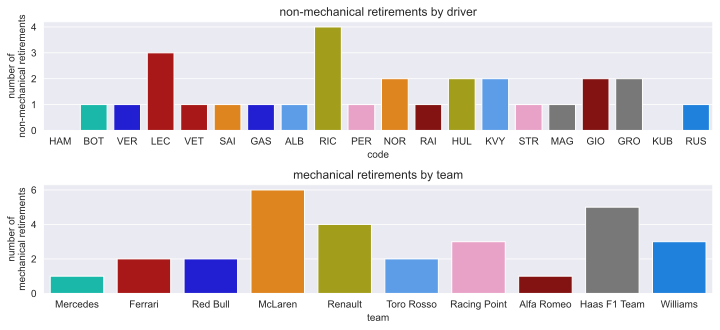

In [29]:
plot_retirements(year=2019);

**Observations**

- No non-mechanical retirements for Hamilton, only one for Bottas. Mercedes has incredible reliability, same with Alfa Romeo
- Riccardo (RIC) has the most non-mechanical retirements
- McLaren and Haas had the worst reliability

# 5 <a id='5'>Lap-by-lap Consistency</a>
[back to top](#top)

Consistency is a major talking point when it comes to the quality of any given driver. We've already discussed consistency in terms of starting and finishing position- but is there another way to quantify the consistency of an F1 driver? 

On possible approach is to study the distribution of lap times during a full race, and further aggregate these results to the full season. For each race, calculate the coefficient of variation $c_v = \frac{\sigma}{\mu}$ ($\sigma$ = standard deviation, $\mu$ = average)- this allows us to compare the spread in lap times race-by-race when the average lap time differs from track to track. 

## 5.1 <a id='5.1'>Filtering</a>
[back to top](#top)

To make a fair comparison, we must only count racing laps- therefore we need to filter out the following: 
- first lap (usually slower than all the others while everyone gets up to speed)
- pit stops and the following out lap 
- safety cars and virtual safety cars (sc)
- retired before a given portion of the race was complete (otherwise that race might give an unfair advantage to overall consistency since there were fewer samples).

In [30]:
def filter_race(df=None, first_lap=True, pit=True, pit_and_outlap=True, sc=True, 
               sc_cutoff=1.2, retirements=True, lap_cutoff=0.8, race="British", year=2019, 
               info=True): 
    
    """Filter race data as needed. 
    Parameters
    ----------
    df: DataFrame
        DataFrame containing pre-loaded race data. If no dataframe is provided, one will be constructed.
    first_lap: boolean
        If True, drops the first lap of the race
    pit_and_outlap: boolean
        If true, drop laps for which 'pit_lap' = True and the following lap
    pit: boolean
        If true, drop laps for which 'pit_lap' = True. This is not evaluated if pit_and_outlap is also True
    sc: boolean
        If true, drop laps that involved a safety car
    sc_cutoff: float (default: 1.3)
        Detection parameter for safety car. If a lap time is sc_cutoff * average time, the we consider that lap to
        involve a safety car
    retirements: boolean
        If true, throw out the laps for drivers that retired and did not complete a certain % of the race 
    lap_cutoff: float
        Throw out drivers 
    race: string
        Default race
    year: int
        Default year
    info: boolean
        If true, return information about average times and safety car laps with the filtered DataFrame
        
    Returns
    ----------
    DataFrame with filtered race data
    
    If info is True: 
    Series- average time for each lap
    float- average lap time for the whole race
    
    If info and sc are true: 
    array - list of safety car laps
    """
    
    finish_status = ["+1 Lap", "+2 Laps", "+3 Laps", "+4 Laps", "Finished"]
    
    # Get the race distribution if one was not already provided. 
    if df is None: 
        df = get_race_distribution(race=race, year=year)
    df['dropped_laps'] = np.nan
    
    laps = df['lap'].sort_values().unique()
    
    # Calculate average lap time during the whole race
    times = pd.Series([np.nanmean(df['lap_time'][df['lap'] == lap]) for lap in laps])
    avg_lap_time = np.nanmean(times)
    
    num_laps = max(laps)
    
    # Loop through all drivers. 
    for driver in df['code'].unique(): 
        
        # Initialize an array of dropped laps. 
        dropped = np.array([])
        
        # Drop first lap. 
        if first_lap: 
            df = df.drop(df[df['lap']==1].index)
            dropped = np.append(dropped, 1)
        
        # Drop pit laps and outlap. 
        if pit_and_outlap:
            drop_laps = df['lap'][(df['code'] == driver) & (df['pit_lap'] == True)].values
            drop_laps2 = np.append(drop_laps, [lap+1 for lap in drop_laps])

            dropped = np.append(dropped, drop_laps2)
            df.drop(df[(df['code'] == driver) & (df['lap'].isin(drop_laps2))].index, inplace=True)
        
        # Drop pit lap only. 
        elif pit: 
            dropped = np.append(dropped, df['lap'][df['pit_lap'] == True].values)
            df = df.drop(df[df['pit_lap'] == True].index)
        
        df.loc[df['code'] == driver, 'dropped_laps'] = str(dropped)
    
    # Drop safety car laps. 
    df['sc_detected'] = df['lap_time'] > sc_cutoff * avg_lap_time
    if sc: 
        sc_laps = [lap for lap in df['lap'].unique() if 
                   len(df['lap'][(df['sc_detected'] == True) & (df['lap'] == lap)]) > 5]
        
        # In addition to the laps for which a safety car was detected, drop the previous lap. 
        for lap in sc_laps: 
            if lap-1 not in sc_laps: 
                sc_laps = np.append(sc_laps, lap-1)
        
        sc_laps.sort()
        
        dropped = np.append(dropped, sc_laps)
        df = df.drop(df[df['lap'].isin(sc_laps)].index)
    
    # Add a list of safety car laps to 'dropped laps' (for validation)
    df['dropped_laps'] = df['dropped_laps'] + str(sc_laps)
        
    # Throw out dirvers that did not complete a certain percentage of the race. This throws out drivers that retired 
    # early in the race while keeping those that may have retired in the later stages since they will still have a 
    # substantial number of lap times.

    if retirements: 
        for driver in df['code'].unique(): 
            if (df['status'][df['code'] == driver].values[0] not in finish_status) &\
               (len(df[df['code'] == driver]) < lap_cutoff * num_laps): 
                
                df = df.drop(df[df['code'] == driver].index)
    if sc & info: 
        return df, times, avg_lap_time, sc_laps
    elif info: 
        return df, times, avg_lap_time
    else: 
        return df

Test the filter function. 

In [31]:
test = filter_race(get_race_distribution(race="British", year=2019))
test[0].head()

,lap,lap_time,pit_lap,position,forename,surname,code,name,year,status,team,dropped_laps,sc_detected
3762,52,87.369,False,1,Lewis,Hamilton,HAM,British Grand Prix,2019,Finished,Mercedes,[ 1. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 4...,False
16580,52,87.369,False,1,Lewis,Hamilton,HAM,British Grand Prix,2019,Finished,Mercedes,[ 1. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 4...,False
5817,52,87.369,False,1,Lewis,Hamilton,HAM,British Grand Prix,2019,Finished,Mercedes,[ 1. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 4...,False
1375,52,87.369,False,1,Lewis,Hamilton,HAM,British Grand Prix,2019,Finished,Mercedes,[ 1. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 4...,False
17495,52,87.369,False,1,Lewis,Hamilton,HAM,British Grand Prix,2019,Finished,Mercedes,[ 1. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 4...,False


sc laps: [ 1  2 22 23]


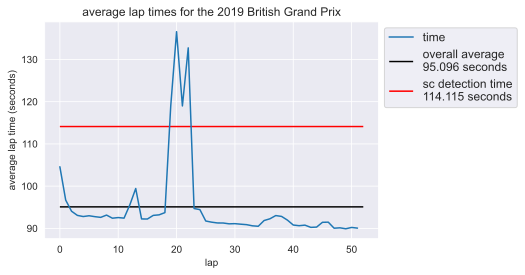

In [32]:
print(f"sc laps: {test[3]}")

fig, ax = plt.subplots()
plt.plot(test[1], label="time")
ax.hlines(y=test[2], color='k', xmin=0, xmax=52, label=f"overall average\n{round(test[2], 3)} seconds")
ax.hlines(y=test[2]*1.2, color='r', xmin=0, xmax=52, label=f"sc detection time\n{round(test[2]*1.2, 3)} seconds")
ax.set_title("average lap times for the 2019 British Grand Prix")
ax.set_xlabel("lap")
ax.set_ylabel("average lap time (seconds)");
ax.legend(bbox_to_anchor=(1,1), loc='upper left', ncol=1, fontsize=MED_FONT);

According to the [race highlights](https://www.youtube.com/watch?v=TjiCXhGuLgw&ab_channel=FORMULA1), the filtering function correctly filtered the safety car period. The lap before safety car deployment (lap 19) was included to handle cars that might be a lap down when the safety car was deployed. 

## 5.2 <a id='5.2'>Plotting lap time distribution for 1 race</a>
[back to top](#top)

In [33]:
def plot_race_distribution(race, year, outliers=False, whis=1.5, cutoff=1.2, colors=colors, bw=1.2, 
                           drop_first_lap=True, drop_pit=True, drop_out_lap=True, style="darkgrid"): 
    """Plot the distribution of lap times over the course of a race"""
    
    df = get_race_distribution(race=race, year=year);
 
    fastest_lap, slowest_lap = df['lap_time'].min(), df['lap_time'].max()
    
    laps = df['lap'].unique()
    laps.sort()
    
    df = filter_race(df, info=False) 
    
    # get the finishing order
    finishing_order = get_race_results(race=race, year=year).sort_values(by="position")['code'].to_numpy()
    
    sns.set_style(style)
    fig, ax = plt.subplots(figsize=[9, 4])
    
    # make plots
    sns.violinplot(ax=ax, 
                   data=df, 
                   y="lap_time", 
                   x="code", 
                   hue="team", 
                   palette=colors, 
                   order=finishing_order, 
                   showfliers=outliers,
                   dodge=False, 
                   bw=bw
                  )
    
    ax.legend(bbox_to_anchor=(1,1), loc='upper left', fontsize=MED_FONT)
    
    ax.set_xlabel("driver", fontsize=MED_FONT)
    ax.set_ylabel("lap time (seconds)", fontsize=MED_FONT),
    ax.set_ylim([(fastest_lap-0.5), fastest_lap*(cutoff)+2])
    ax.tick_params(labelsize=10)
    ax.autoscale(enable=True)
    ax.set_title(f"Lap time distribution for the {year} {df['name'].values[0]}\n", fontsize=BIG_FONT)
    return ax, df

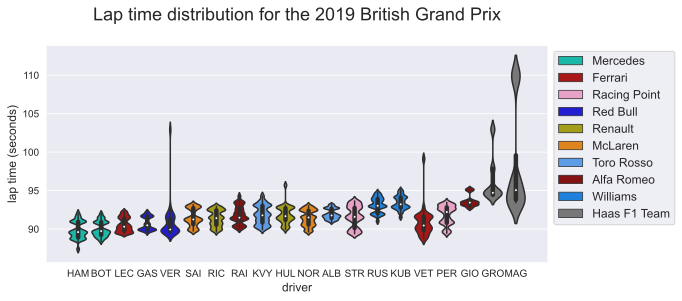

In [34]:
ax, df = plot_race_distribution(race="British", year=2019, cutoff=1.2, bw=0.2);

The outliers with Vettel and Verstappen are due to their collision on lap 37, as explained in section 1. It appears that here, Verstappen is punished more than Vettel with respect to consistency, even though the [replay](https://youtu.be/TjiCXhGuLgw?t=333) clearly shows it was Vettel's fault. Unfortunately, there's no clear way to tease out who was at fault just from this dataset without watching the replay, so we will keep things as they are. 


It looks like there are a couple outliers for Verstappen and Vettel- what's going on with these laps?

## 5.3 <a id='5.3'>Coefficients of variation over a season</a>
[back to top](#top)

One way to judge the overall consistency of a driver is to look at the distribution of lap times during a race. The hypothesis here is that the better drivers are the one that put in more consistent lap times. This is affected by tire choice, since the stiffness of tire compounds directly influence lap time; however, we can run under the assumption that these differences average out over a season.

In [35]:
def calc_variations(year=2019, plot=True, team_abbrev=team_abbrev, bw=.15, top_filter=1): 
    """Plot the distrubution of lap time variations for each driver over the course of a season.
    
    Parameters
    -------
    year: int
        Season of interest (default: 2019)
    plot: boolean
        If true, plots are automatically generated, if false, only calculated data frames are returned
    team_abbrev: defaultdict
        dictionary of team abbreviations. In the case of mid season driver changes (e.g. Pierre Gasly and 
        Alex Albon's swap in 2019), the lap time distribution is segregated between each team and the team abbreviation
        is appended to the driver code for better discernment. 
    bw: float
        bw argument for sns.violinplot
    top_filter: float
        Remove the data points if the coefficient of variation is above a threshold
        
    Returns
    -------
    df: merged DataFrame containing the race variation info and season results
    season_results: DataFrame containing the standings at the end of the selected season
    race_data: DataFrame with the coefficient of variation for each race for each driver
    Axes: array with the 2 axis handles for each plot (only returned if plot is True)
    """
    
    races_query = """
    SELECT name
    FROM races
    WHERE year = %(year)s
    ORDER BY round
    """
    
    drivers_query = """
    SELECT DISTINCT drivers.code
    FROM drivers
    JOIN driver_standings ON driver_standings.driverid = drivers.driverid
    JOIN races ON races.raceid = driver_standings.raceid
    WHERE races.year = %(year)s
    """
    
    # Get all the races in a single season.
    races = query(races_query, var={'year': year})['name'].to_numpy() 
    
    # races = np.delete(races, "German Grand Prix")
    # get the drivers for a given season
    drivers = query(drivers_query, var={'year': year})['code'].to_numpy()             
    
    # initialize a dataframe for the coefficients of variation in every race
    race_data = pd.DataFrame(columns = ['race', 'team',  'coef_of_var', 'laps_counted', 'status'])
    
    # get the final season standings
    season_results = get_final_season_results(year)
    
    # loop through each race and calculate the coefficient of variation for each driver
    for race in races: 
        try:
            race_dist = filter_race(get_race_distribution(race, year), info=False) 
        except Exception as e: 
            print(f"no data for {race}")
            print(str(e))
        
        num_laps = max(race_dist['lap'].values)
        num_finishers = len(race_dist['code'].unique())
        
        
        # loop through each driver
        for driver in race_dist['code'].unique():
            lap_times = race_dist['lap_time'][race_dist['code'] == driver].values
            laps = race_dist['lap'][race_dist['code'] == driver].values
            
            # Calculate average and standard deviation. 
            avg  = np.nanmean(lap_times)
            sd   = np.nanstd(lap_times)
            if sd/avg > top_filter:
                print(f"skipping: race={race}; driver={driver}")
                continue
            # Get other needed metrics
            team = race_dist['team'][race_dist['code'] == driver].values[0]
            status = race_dist['status'][race_dist['code'] == driver].values[0]
            max_lap = str(max(laps))
            
            laps_counted = str(len(laps)) + "/" + str(max(laps))
            # append to dataframe

            race_data = race_data.append({'race'       : race,
                                          'code'       : driver, 
                                          'team'       : team, 
                                          'status'     : status, 
                                          'laps_counted': laps_counted,
                                          'coef_of_var': sd/avg}, 
                                           ignore_index=True)
            
    # merge the race data and season results to properly order the drivers
    df = pd.merge(race_data, season_results, left_on='code', right_on='code')

    # handle mid-season driver switches
    # add team abbreviation to driver code if they drove for multiple teams in the same season
    df = team_switches(df)

            
    # return the dataframes if we're not plotting anything
    if plot == False: 
         return df, season_results, race_data
        
     # make box plots, order by drivers standings
    fig, ax = plt.subplots(nrows=2, figsize=[8,8])
    
    plt.subplots_adjust(hspace=0.7)
    sns.violinplot(data=df, 
                   x='code',
                   y='coef_of_var', 
                   ax=ax[0], 
                   hue='team', 
                   palette=colors, 
                   dodge=False,
                   bw=bw, 
                   order=df.sort_values(by='points', ascending=False)['code'].unique()
                   )

    ax[0].set_title(f"\nCoefficient of variation distributions for the {year} season\nordered by driver standings\n", 
                    fontsize=BIG_FONT)
    

    # order by average coefficient of variation
    order_var = pd.DataFrame(columns = ['code', 'avg_coef_of_var'])
    
    for driver in df['code'].unique(): 
        avg_var = np.nanmean(df['coef_of_var'][df['code']==driver])
        order_var = order_var.append({'code': driver, 'avg_coef_of_var': avg_var}, ignore_index=True)

    sns.violinplot(data=df, 
                x=df['code'], 
                y='coef_of_var', 
                ax=ax[1], 
                hue='team', 
                palette=colors, 
                dodge=False,
                bw=bw,
                order=order_var.sort_values(by='avg_coef_of_var')['code'].to_numpy()
               )

    ax[1].set_title(f"\nCoefficient of variation distributions for the {year} season\nordered by lowest average variation\n",
                    fontsize = BIG_FONT)
    
    # format axes
    for i in [0,1]:
        ax[i].set_xlabel("driver\n",                 fontsize=MED_FONT)
        ax[i].set_ylabel("coefficient of variation", fontsize=MED_FONT)
        ax[i].tick_params(axis='x',                  labelsize=SMALL_FONT)
        ax[i].tick_params(axis='y',                  labelsize=SMALL_FONT)
        ax[i].legend(bbox_to_anchor=(1,1), loc = 'upper left', ncol=1, fontsize=MED_FONT)
    return df, season_results, race_data, [ax[0], ax[1]]

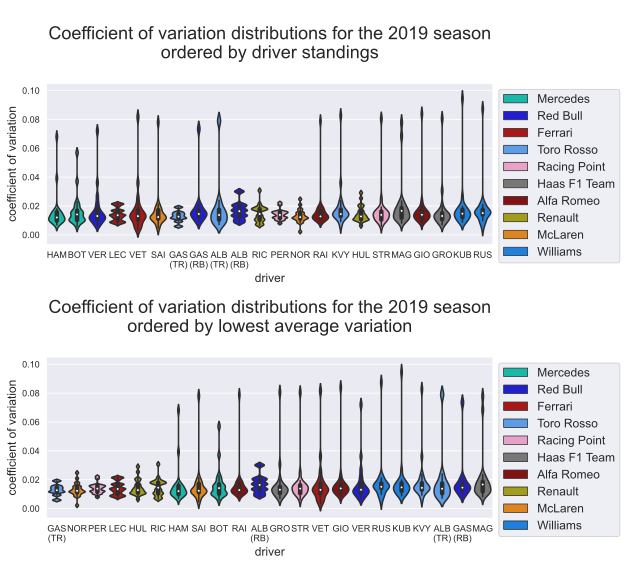

In [36]:
cons_df, _, _, _ = calc_variations(year=2019, plot=True);

Where are these outliers coming from?

In [37]:
print("least consistent races")
cons_df.sort_values(by='coef_of_var', ascending=False).head(10)

least consistent races


,race,team,coef_of_var,laps_counted,status,code,forename,surname,points,wins
364,German Grand Prix,Williams,0.094500,500/64,Finished,KUB,Robert,Kubica,1,0
343,German Grand Prix,Williams,0.087392,500/64,Finished,RUS,George,Russell,0,0
322,German Grand Prix,Alfa Romeo,0.083859,500/64,Finished,GIO,Antonio,Giovinazzi,14,0
114,German Grand Prix,Toro Rosso,0.082657,500/64,Finished,KVY,Daniil,Kvyat,37,0
177,German Grand Prix,Ferrari,0.081587,500/64,Finished,VET,Sebastian,Vettel,240,1
240,German Grand Prix,Haas F1 Team,0.080640,500/64,Finished,GRO,Romain,Grosjean,8,0
135,German Grand Prix,Racing Point,0.080462,500/64,Finished,STR,Lance,Stroll,21,0
301,German Grand Prix,Toro Rosso,0.079024,500/64,Finished,ALB\n(TR),Alexander,Albon,92,0
198,German Grand Prix,Alfa Romeo,0.078783,500/64,Finished,RAI,Kimi,Räikkönen,43,0
406,German Grand Prix,McLaren,0.077985,500/64,Finished,SAI,Carlos,Sainz,96,0


**Observations** 
- Pierre Gasly (GAS), while at Red Bull, had the lowest average coefficient of variation for the 2019 season. This is somewhat surprising, as he was constantly criticized for his lack of consistency.
- The German Grand Prix is skewing results. This is because the race started in the wet and slowly dried out, which means most drivers put in laps on some combination of wet and dry tires- leading to a large variation in lap times. 
- Drivers without significant outliers (GAS, RIC, PER, BOT, HUL) all retired from the German Grand Prix- which means they benefited from a lower variance despite retiring from one of the most challenging races of the season. 
- The order of lowest average coefficient of variation is extremely sensitive to how laps are filtered. 

- Clearly, there is no significant difference in the distribution of lap times over the course of a season, meaning that this is not a good indicator of driver quality.

# 6 <a id='6'>Conclusion</a>
[back to top](#top)

In this project, we explored several visualizations related to the 2019 Formula 1 season. The British Grand Prix was visualized lap-by-lap via the race trace, where we were able to identify retirements, pit stops, and safety cars. The distribution of start / finishing positions found that most teammates are matched evenly, except for Red Bull. An analysis of retirements showed that Leclerc and Riccardo had the most non-mechanical retirements, while McLaren and Haas had the worst reliability. Finally, we attempted to rank the consistency of F1 drivers by studying the variance in lap times race-by-race. Presently, this methodology is not a viable metric for measuring driver quality. A likely reason that this is not a good metric is because the assumption that the differences in lap times due to different tire compounds average out is not valid. In the next update of this project, individual stints will be aggregated instead of entire races. 